In [1]:
import pandas as pd
import quandl
import matplotlib.pyplot as plt
import math

In [32]:
def variance_calculator(series,series_average,win_len):
    sma = win_len #lag
    temp = series.subtract(series_average) #summation(a-b)
    temp1 = temp.apply(lambda x:x**2) #summation(a-b)^2
    temp2 = temp1.rolling(sma-1).mean() #summation (a-b)^2/sma-1
    sigma = temp2.apply(lambda x:math.sqrt(x))
    return sigma

In [33]:
data1 = quandl.get("CHRIS/CME_SP1", authtoken = "5Fxm1Dgr5fZvbyeVQUpG" , start_date = "2019-01-01")
declining = quandl.get("URC/NYSE_DEC", authtoken = "5Fxm1Dgr5fZvbyeVQUpG" , start_date = "2019-01-01")
advancing = quandl.get("URC/NYSE_ADV", authtoken = "5Fxm1Dgr5fZvbyeVQUpG" , start_date = "2019-01-01")
adv_vol = quandl.get("URC/NYSE_ADV_VOL", authtoken = "5Fxm1Dgr5fZvbyeVQUpG" , start_date = "2019-01-01")
dec_vol = quandl.get("URC/NYSE_DEC_VOL", authtoken = "5Fxm1Dgr5fZvbyeVQUpG" , start_date = "2019-01-01")

In [34]:
data = declining
data['declining'] = declining['Numbers of Stocks']
data['advancing'] = advancing['Numbers of Stocks']
data['dec_vol'] = dec_vol['Numbers of Stocks']
data['adv_vol'] = adv_vol['Numbers of Stocks']


In [35]:
merged = data.join(data1)
merged = merged.fillna(method = 'ffill')
data = merged

In [36]:
data.head()

,Numbers of Stocks,declining,advancing,dec_vol,adv_vol,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,,,,,,
2019-01-02,909.0,909.0,2111.0,1.110773e+09,2.545811e+09,2511.4,2520.9,2453.0,2511.5,5.8,2511.0,1302.0,36741.0
2019-01-03,1742.0,1742.0,1242.0,2.536077e+09,1.248001e+09,2480.9,2492.5,2445.0,2449.0,63.3,2447.7,2281.0,36333.0
2019-01-04,276.0,276.0,2732.0,1.894057e+08,3.987383e+09,2453.4,2538.0,2439.0,2531.0,83.6,2531.3,5884.0,37192.0
2019-01-07,650.0,650.0,2371.0,7.920689e+08,3.272190e+09,2536.7,2567.0,2524.2,2550.5,19.3,2550.6,4837.0,39216.0
2019-01-08,681.0,681.0,2324.0,1.213438e+09,2.831057e+09,2550.7,2581.0,2549.0,2571.8,21.8,2572.4,3548.0,42609.0


In [37]:
ad_ratio = data['advancing'].divide(data['declining']) # AD Ratio

In [38]:
ad_vol = data['adv_vol'].divide(data['dec_vol']) # AD Volume Ratio

In [39]:
trin = ad_ratio.divide(ad_vol)  # TRIN Value

In [40]:
data['TRIN'] = trin
data['TRIN'] = data['TRIN'].apply(lambda x: math.log(x))
data['future'] = data['Last']
data.to_csv("tempr_data.csv")

In [41]:
data= pd.read_csv("tempr_data.csv")

In [42]:
data.head()

,Date,Numbers of Stocks,declining,advancing,dec_vol,adv_vol,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,TRIN,future
0,2019-01-02,909.0,909.0,2111.0,1.110773e+09,2.545811e+09,2511.4,2520.9,2453.0,2511.5,5.8,2511.0,1302.0,36741.0,0.013179,2511.5
1,2019-01-03,1742.0,1742.0,1242.0,2.536077e+09,1.248001e+09,2480.9,2492.5,2445.0,2449.0,63.3,2447.7,2281.0,36333.0,0.370764,2449.0
2,2019-01-04,276.0,276.0,2732.0,1.894057e+08,3.987383e+09,2453.4,2538.0,2439.0,2531.0,83.6,2531.3,5884.0,37192.0,-0.754611,2531.0
3,2019-01-07,650.0,650.0,2371.0,7.920689e+08,3.272190e+09,2536.7,2567.0,2524.2,2550.5,19.3,2550.6,4837.0,39216.0,-0.124472,2550.5
4,2019-01-08,681.0,681.0,2324.0,1.213438e+09,2.831057e+09,2550.7,2581.0,2549.0,2571.8,21.8,2572.4,3548.0,42609.0,0.380290,2571.8


In [43]:
sma = 22 #  Moving Average Window length
k = 1.5 # Constant representing 'k' times sigma away from moving average (fir Bollinger bands)
l = 2 # cons.representing 'l' times sigma away from Bollinger band (for stoploss band) 
pro = 0  # Profit Variable
flag = 1 # Flag is there for begin first transaction -- transaction should start with LBB/UBB crossing only
buy_flag = False
sell_flag = False
transaction_start_price = 0
abs_SL = 25  # Absolute Stoploss Variable
mtm = list()
order_details = list()
order = list()  #list which contains the orders: BUY / SELL / Do Nothing
profit = list()
buy_sell = list()
stoploss = list()
trade_cause = list()


In [44]:
data['mAvg'] = data['TRIN'].rolling(sma).mean() # Calculating the moving average of the TRIN
data['TRIN_prev'] = data['TRIN'].shift(1)
data.to_csv("tempr_data.csv")
data = pd.read_csv("tempr_data.csv")

In [45]:
sigma = variance_calculator(data['TRIN'], data['mAvg'], sma )  # Calculating the standard deviation
k_sigma = k * sigma
l_sigma = l * sigma

In [46]:
data['UBB'] = data['mAvg'].add(k_sigma) # Upper Bollinger Band
data['LBB'] = data['mAvg'].subtract(k_sigma)  # Lower Bollinger Band
data['USL'] = data['UBB'].add(l_sigma)  # Upper Stoploss Band
data['LSL'] = data['LBB'].subtract(l_sigma)  # Lower Stoploss Band
data['order'] = pd.Series() # list which contains the orders: BUY / SELL / Do Nothing

In [47]:
s = data['TRIN'].size  # Total Number of data point


In [48]:
#trading strategy
for i in range(s):

    pro = 0
    future_cost = data['future'][i]
    TRIN = data['TRIN'][i]
    TRIN_prev = data['TRIN_prev'][i]
    LBB = data['LBB'][i]
    UBB = data['UBB'][i]
    mAvg = data['mAvg'][i]
    USL = data['USL'][i]
    LSL = data['LSL'][i]


    UBB_cross = (TRIN > UBB) and (TRIN_prev < UBB)  # Check if TRIN crosses Upper Bollinger Band
    LBB_cross = (TRIN < LBB) and (TRIN_prev > LBB)  # Check if TRIN crosses Lower Bollinger Band
    mAvg_cross_up = (TRIN > mAvg) and (TRIN_prev < mAvg)  # Check if TRIN crosses moving average from low to high
    mAvg_cross_down = (TRIN < mAvg) and (TRIN_prev > mAvg)  # Check if TRIN crosses moving average from high to low
    USL_cross = (TRIN > USL) and (TRIN_prev < USL) # Check if TRIN Crosses upper stoploss band
    LSL_cross = (TRIN < LSL) and (TRIN_prev > LSL) # Check if TRIN Crosses lower stoploss band

    # Strategy
    if(UBB_cross and (not buy_flag) and flag == 1):
        flag = 0
        buy_flag = True
        sell_flag = False
        transaction_start_price = future_cost
        order_details = [1, "Buy", "UBB Crossed", "0", "Position taken"]
    
    elif(LBB_cross and (not sell_flag) and flag == 1):
        flag = 0
        sell_flag = True
        buy_flag = False
        transaction_start_price = future_cost
        order_details = [-1, "Sell", "LBB Crossed", "0", "Position taken"]

    elif(mAvg_cross_up and (not buy_flag) and flag == 0):  # Places "BUY" order if TRIN crosses mAvg from low to high to close a trade
        flag = 1
        buy_flag = False
        sell_flag = False
        pro = future_cost - transaction_start_price
        order_details = [1, "Buy", "mAvg Crossed", "0", "Position Closed"]

    elif(LSL_cross and (not buy_flag) and flag == 0):  # Places "BUY" order if TRIN crosses lower stoploss band to close a trade
        flag = 1
        buy_flag = False
        sell_flag = False
        pro = future_cost - transaction_start_price
        order_details = [1, "Buy", "LSB Crossed", "Stoploss Executed", "Position Closed"]

    elif((future_cost - transaction_start_price) > abs_SL and (not buy_flag) and flag == 0):  # Places "BUY" order if TRIN crosses lower stoploss absolute value
        flag = 0
        buy_flag = False
        sell_flag = False
        pro = future_cost - transaction_start_price
        order_details = [1, "Buy", "LSB Crossed", "Stoploss Executed", "Position Closed"]

    elif(mAvg_cross_down and (not sell_flag) and flag == 0):  # Places "Sell" order if TRIN crosses mAvg from high to low to close a trade
        flag = 1
        buy_flag = False
        sell_flag = False
        pro = - (future_cost - transaction_start_price)
        order_details = [-1, "Sell", "mAvg Crossed (H to L)", "0", "Position Closed"]

    elif(USL_cross and (not sell_flag) and flag == 0):  # Places "Sell" order if TRIN crosses Upper stoploss band to close a trade
        flag = 1
        buy_flag = False
        sell_flag = False
        pro = - (future_cost - transaction_start_price)
        order_details = [-1, "Sell", "USB Crossed", "Stoploss Executed", "Position Closed"]

    elif( (- future_cost - transaction_start_price) > abs_SL and (not sell_flag) and flag == 0):  # Places "SELL" order if TRIN crosses Upper stoploss absolute value
        flag = 1
        buy_flag = False
        sell_flag = False
        pro = - (future_cost - transaction_start_price)
        order_details = [-1, "Sell", "USB Crossed", "Abs Stoploss Executed", "Position Closed"]

    else:
        if(buy_flag == 0 and sell_flag == 0):
            tempo = "0"
        else:
            if(buy_flag == 1 and sell_flag == 0):
                tempo = (data['future'][i] - transaction_start_price) * 500
            if(buy_flag == 0 and sell_flag == 1):
                tempo = (- data['future'][i] + transaction_start_price) * 500
        order_details = [0, "No Trade", "No Trade", "0", tempo]

    profit.append(pro)
    order.append(order_details[0])
    buy_sell.append(order_details[1])
    trade_cause.append(order_details[2])
    stoploss.append(order_details[3])
    mtm.append(order_details[4])

In [49]:
data['placed_order'] = pd.Series(order)  # Converting list into Panda Series
data['cost'] = - (data['placed_order'].multiply(data['future'])) * 500  #  Cost of each transaction
data['out'] = data['cost'].cumsum()   # Out is the cumulative cost profit / loss after transaction till now
data['buy_sell'] = pd.Series(buy_sell)
data['profit'] = -pd.Series(profit) * 500
data['stoploss'] = pd.Series(stoploss)
data['trade_cause'] = pd.Series(trade_cause)
data['mtm'] = pd.Series(mtm)

In [51]:
print(data['out'].head())

0   -0.0
1   -0.0
2   -0.0
3   -0.0
4   -0.0
Name: out, dtype: float64


In [52]:
output = pd.DataFrame() # Final output to be stored in excel file
output['date'] = data['Date']
output['Close'] = data['future']
output['TRIN'] = data['TRIN']
output['placed_order'] = data['placed_order']
output['buy_sell'] = data['buy_sell']
output['trade_cause'] = data['trade_cause']
output['PnL'] = data['profit']
output['mtm'] = data['mtm']
output['stoploss'] = data['stoploss']
output['Cash Account'] = data['out']

In [53]:
output.to_excel('TRIN_SL_output.xlsx', sheet_name='Sheet1')

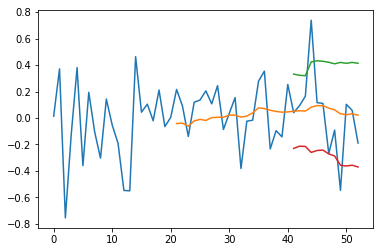

In [54]:
# Plot
plt.plot(data['TRIN'])
plt.plot(data['mAvg'])
plt.plot(data['UBB'])
plt.plot(data['LBB'])
plt.show()